The goal of this notebook is to use historical data from a loan company to develop a model which is going to be able to determine whether a loan request should be approved or denied when the customer 

In [2]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report

%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_train.csv')
test = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_test.csv')

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [5]:
train['Married'] = train['Married'].fillna('No')
train['Dependents'] = train['Dependents'].fillna(0)
train['Self_Employed'] = train['Self_Employed'].fillna('No')
train['LoanAmount'] = train['LoanAmount'].fillna(train['LoanAmount'].mean())
train['Loan_Amount_Term'] = train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mean())
train['Credit_History'] = train['Credit_History'].fillna(0)


In [6]:
train = train.dropna()

In [7]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

In [8]:
cat = cat.drop(columns='Loan_Status')

In [9]:
#chi2 correlation test for cat values

chi2_results = []

#for loop to iterate over cat features

for feature in cat:
    contingency_table = pd.crosstab(train[feature], train['Loan_Status'])

    _, p, _, _ = chi2_contingency(contingency_table)

    chi2_results.append({
        'Feature' : feature,
        'p-value' : p,
        'Significant (p < 0.05)' : p< 0.05 
    })

chi2_df = pd.DataFrame(chi2_results).sort_values(by='p-value')

print(chi2_df)

         Feature   p-value  Significant (p < 0.05)
6  Property_Area  0.002243                    True
2        Married  0.038668                    True
4      Education  0.052975                   False
3     Dependents  0.255940                   False
0        Loan_ID  0.480820                   False
1         Gender  0.708653                   False
5  Self_Employed  0.747003                   False


After running the chi2 test for all of the categorical values we can confirm that only 2 features have statistical meaning to the target:

- Property_Area
- Married

The rest of the features can be dropped to facilitate the learning phase of the model.

I'm going to proceed and create a correlation matrix but in order for me to do that I will need to encode the dataframe accordingly.

In [10]:
#dropping columns which are no longer needed

train = train.drop(columns=['Education', 'Dependents', 'Loan_ID', 'Gender', 'Self_Employed'])

train.sample(10)

,Married,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
232,No,3189,2598.0,120.0,342.0,1.0,Rural,Y
498,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y
445,Yes,3466,1210.0,130.0,360.0,1.0,Rural,Y
91,Yes,6250,5654.0,188.0,180.0,1.0,Semiurban,Y
245,No,6050,4333.0,120.0,180.0,1.0,Urban,N
84,Yes,3988,0.0,50.0,240.0,1.0,Urban,Y
601,Yes,2894,2792.0,155.0,360.0,1.0,Rural,Y
489,No,2435,0.0,75.0,360.0,1.0,Urban,N
330,No,4384,1793.0,117.0,360.0,1.0,Urban,Y
293,No,5417,0.0,143.0,480.0,0.0,Urban,N


In [11]:
train.columns = train.columns.str.lower()

In [12]:
property_grouped = train.groupby('property_area')['applicantincome'].mean()
property_grouped

property_area
Rural        5507.805714
Semiurban    5261.035242
Urban        5152.095477
Name: applicantincome, dtype: float64

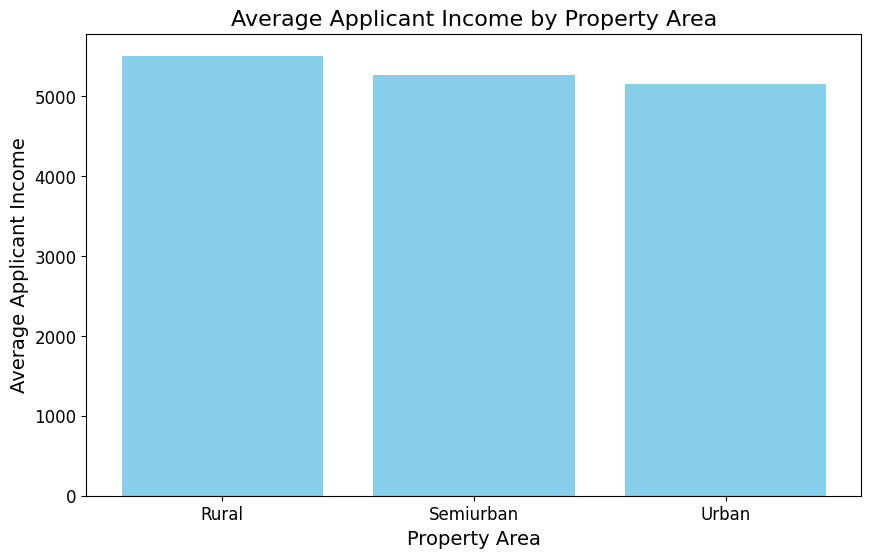

In [13]:
#plotting the grouped data

bars = property_grouped.index
height = property_grouped.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Property Area', fontsize=14)
plt.ylabel('Average Applicant Income', fontsize=14)
plt.title('Average Applicant Income by Property Area', fontsize=16)

plt.show()

In [14]:
property_filtered_rural = train.copy()

property_filtered_rural = property_filtered_rural.loc[(property_filtered_rural['property_area'] == 'Rural')]

In [15]:
property_filtered_semi = train.copy()
property_filtered_semi = property_filtered_semi.loc[(property_filtered_semi['property_area'] == 'Semiurban')]

In [16]:
property_filtered_urban = train.copy()
property_filtered_urban = property_filtered_urban.loc[(property_filtered_urban['property_area'] == 'Semiurban')]

In [17]:
crosstab_rural = pd.crosstab(property_filtered_rural['property_area'], property_filtered_rural['loan_status'])
crosstab_rural

loan_status,N,Y
property_area,,
Rural,67,108


In [18]:
crosstab_semi = pd.crosstab(property_filtered_semi['property_area'], property_filtered_semi['loan_status'])
crosstab_semi

loan_status,N,Y
property_area,,
Semiurban,52,175


In [19]:
crosstab_urban = pd.crosstab(property_filtered_urban['property_area'], property_filtered_urban['loan_status'])
crosstab_urban

loan_status,N,Y
property_area,,
Semiurban,52,175


The requests stemming from the rural area present a higher mean of income, followed by the semiurban and urban area.

Above we can see the bivariate analysis for all of the 3 areas.

In the future we might create a new numerical column for the train df which would be the result of the requestant income + the income of the partner.

In [20]:
#encoding the categorical features of train

married_dummies = pd.get_dummies(train["married"], prefix="married", dtype=int)
married_dummies

,married_No,married_Yes
0,1,0
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
609,1,0
610,0,1
611,0,1
612,0,1


In [21]:
train = pd.concat([train, married_dummies], axis=1)

train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0
...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1


In [22]:
loan_dummies = pd.get_dummies(train['loan_status'], prefix='loan', dtype=int)
loan_dummies

,loan_N,loan_Y
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1
...,...,...
609,0,1
610,0,1
611,0,1
612,0,1


In [23]:
train = pd.concat([train, loan_dummies], axis= 1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1


In [24]:
urban_area_dummiers = pd.get_dummies(train['property_area'], dtype= int)
urban_area_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
609,1,0,0
610,1,0,0
611,0,0,1
612,0,0,1


In [25]:
train = pd.concat([train, urban_area_dummiers], axis=1)
train

,married,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,loan_status,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,No,5849,0.0,146.412162,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
1,Yes,4583,1508.0,128.000000,360.0,1.0,Rural,N,0,1,1,0,1,0,0
2,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
3,Yes,2583,2358.0,120.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
4,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,No,2900,0.0,71.000000,360.0,1.0,Rural,Y,1,0,0,1,1,0,0
610,Yes,4106,0.0,40.000000,180.0,1.0,Rural,Y,0,1,0,1,1,0,0
611,Yes,8072,240.0,253.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1
612,Yes,7583,0.0,187.000000,360.0,1.0,Urban,Y,0,1,0,1,0,0,1


In [26]:
train = train.drop(columns= ['married', 'property_area', 'loan_status'])
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [27]:
train.columns

Index(['applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'married_No', 'married_Yes',
       'loan_N', 'loan_Y', 'Rural', 'Semiurban', 'Urban'],
      dtype='object')

In [28]:
test.columns = test.columns.str.lower()

test = test.drop(columns=['loan_id', 'gender'])

In [29]:
test = test.dropna()

In [30]:
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban
...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural


In [31]:
#encoding the categorical features of train

married_test_dummies = pd.get_dummies(test["married"], prefix="married", dtype=int)
married_test_dummies

,married_No,married_Yes
0,0,1
1,0,1
2,0,1
4,1,0
5,0,1
...,...,...
361,0,1
362,0,1
363,0,1
365,0,1


In [32]:
urban_area_test_dummiers = pd.get_dummies(test['property_area'], dtype= int)
urban_area_test_dummiers

,Rural,Semiurban,Urban
0,0,0,1
1,0,0,1
2,0,0,1
4,0,0,1
5,0,0,1
...,...,...,...
361,0,1,0
362,0,0,1
363,0,0,1
365,1,0,0


In [33]:
test = pd.concat([test, married_test_dummies], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1


In [34]:
test = pd.concat([test, urban_area_test_dummiers], axis=1)
test

,married,dependents,education,self_employed,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,property_area,married_No,married_Yes,Rural,Semiurban,Urban
0,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,0,1,0,0,1
1,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,0,1,0,0,1
2,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,0,1,0,0,1
4,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,1,0,0,0,1
5,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1.0,Urban,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,Yes,1,Graduate,No,2269,2167,99.0,360.0,1.0,Semiurban,0,1,0,1,0
362,Yes,3+,Not Graduate,Yes,4009,1777,113.0,360.0,1.0,Urban,0,1,0,0,1
363,Yes,0,Graduate,No,4158,709,115.0,360.0,1.0,Urban,0,1,0,0,1
365,Yes,0,Graduate,No,5000,2393,158.0,360.0,1.0,Rural,0,1,1,0,0


In [35]:
train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,loan_N,loan_Y,Rural,Semiurban,Urban
0,5849,0.0,146.412162,360.0,1.0,1,0,0,1,0,0,1
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,1,0,0
2,3000,0.0,66.000000,360.0,1.0,0,1,0,1,0,0,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,1,0,0,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,0,1,1,0,0
610,4106,0.0,40.000000,180.0,1.0,0,1,0,1,1,0,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,1,0,0,1
612,7583,0.0,187.000000,360.0,1.0,0,1,0,1,0,0,1


In [36]:
test = test.drop(columns=['married', 'dependents', 'education', 'self_employed', 'property_area'])
test

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban
0,5720,0,110.0,360.0,1.0,0,1,0,0,1
1,3076,1500,126.0,360.0,1.0,0,1,0,0,1
2,5000,1800,208.0,360.0,1.0,0,1,0,0,1
4,3276,0,78.0,360.0,1.0,1,0,0,0,1
5,2165,3422,152.0,360.0,1.0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
361,2269,2167,99.0,360.0,1.0,0,1,0,1,0
362,4009,1777,113.0,360.0,1.0,0,1,0,0,1
363,4158,709,115.0,360.0,1.0,0,1,0,0,1
365,5000,2393,158.0,360.0,1.0,0,1,1,0,0


In [37]:
#moving the target on the right of the df

loan_y_col = train.pop('loan_Y')
train['loan_Y'] = loan_y_col

loan_n_col = train.pop('loan_N')
train['loan_N'] = loan_n_col

train

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,loan_N
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1,0
1,4583,1508.0,128.000000,360.0,1.0,0,1,1,0,0,0,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1,0
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1,0
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
609,2900,0.0,71.000000,360.0,1.0,1,0,1,0,0,1,0
610,4106,0.0,40.000000,180.0,1.0,0,1,1,0,0,1,0
611,8072,240.0,253.000000,360.0,1.0,0,1,0,0,1,1,0
612,7583,0.0,187.000000,360.0,1.0,0,1,0,0,1,1,0


In [38]:
#dropping loan_N as redundant

train = train.drop(columns='loan_N')

Now that I have completed the EDA, encoded and prepared the df, I can create a first baseline Logistic Regression model to see how it performs without any hyperparameters tuning.

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = train.drop(columns='loan_Y')
y = train['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


baseline = LogisticRegression()

baseline.fit(X_train_scaled, y_train)

print("train data length: ", len(X_train_scaled))
print("test data length", len(X_test_scaled))


train data length:  480
test data length 121


In [40]:
predictions_baseline = baseline.predict(X_test_scaled)

predictions_baseline

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

In [41]:
predictions_df = X_test.copy()

predictions_df['loan_Y'] = predictions_baseline

predictions_df['actual_loan_Y'] = y_test

predictions_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,actual_loan_Y
111,2929,2333.0,139.0,360.0,1.0,0,1,0,1,0,1,1
425,2666,4300.0,121.0,360.0,1.0,0,1,1,0,0,1,1
575,3159,461.0,108.0,84.0,1.0,0,1,0,0,1,1,1
78,3167,4000.0,180.0,300.0,0.0,0,1,0,1,0,0,0
184,3625,0.0,108.0,360.0,1.0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
346,3523,3230.0,152.0,360.0,0.0,0,1,1,0,0,0,0
150,6277,0.0,118.0,360.0,0.0,1,0,1,0,0,0,0
503,4050,5302.0,138.0,360.0,0.0,0,1,1,0,0,0,0
445,3466,1210.0,130.0,360.0,1.0,0,1,1,0,0,1,1


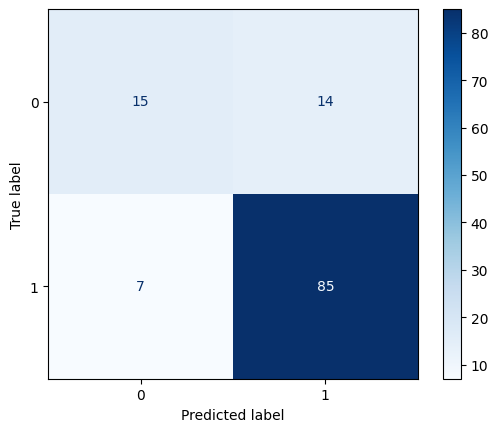

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = predictions_df['actual_loan_Y']
y_pred = predictions_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [43]:
print(classification_report(y_test, predictions_baseline))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59        29
           1       0.86      0.92      0.89        92

    accuracy                           0.83       121
   macro avg       0.77      0.72      0.74       121
weighted avg       0.82      0.83      0.82       121



The model performs fairly good but there's definitely room for improvement.

We can see that the baseline model seems to be better at predicting when the loan should be approved than when it shouldn't.

For the True label we got 7 false negatives and 14 false positives.

I am now going to apply some more feature engineering and hyperparameters tuning as well as reviewing the mismatch in the data between requests being accepted and denied.

In [44]:
loan_y_n_frequency = train['loan_Y'].value_counts()
loan_y_n_frequency

loan_Y
1    414
0    187
Name: count, dtype: int64

As we can see from the above we have a clear mismatch between data which led to approval and data which led to denial.

I'm going to focus on increasing the data which led to denial with synthetic data.

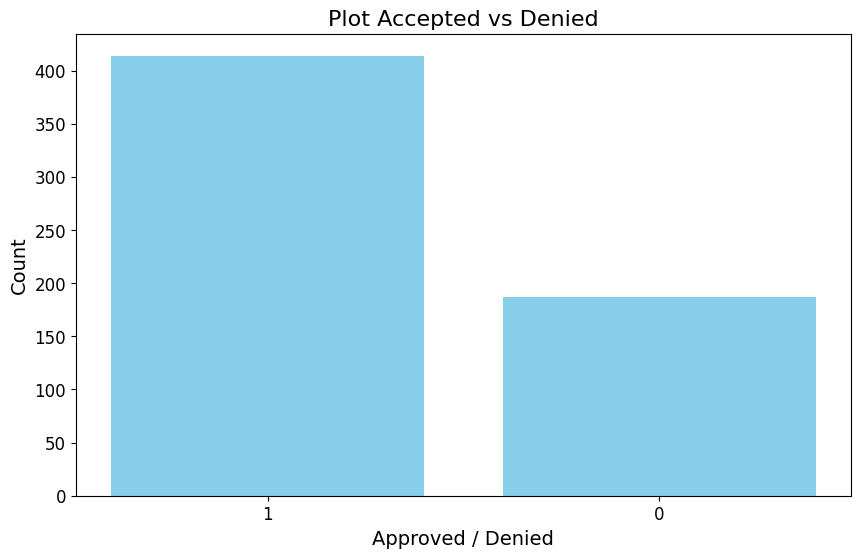

In [45]:
#plotting mismatch between approved and denied in the train data

bars = loan_y_n_frequency.index
height = loan_y_n_frequency.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Approved / Denied', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Plot Accepted vs Denied', fontsize=16)

plt.show()

In [46]:
from sklearn.utils import resample

no_approval = train[train['loan_Y']==0]
approval  = train[train['loan_Y']==1]

oversampled_no_approval = resample(no_approval, replace=True, n_samples=len(approval), random_state=42)  # Reproducible results

display(approval.shape)
display(oversampled_no_approval.shape)



(414, 11)

(414, 11)

In [47]:
train_oversampled = pd.concat([approval, oversampled_no_approval])

train_oversampled

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1
5,5417,4196.0,267.000000,360.0,1.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36,1828,1330.0,100.000000,342.0,0.0,0,1,0,0,1,0
168,2237,0.0,63.000000,480.0,0.0,1,0,0,1,0,0
328,4333,2451.0,110.000000,360.0,1.0,0,1,0,0,1,0
22,2600,1911.0,116.000000,360.0,0.0,0,1,0,1,0,0


In [48]:
frequency_table_oversampled = train_oversampled['loan_Y'].value_counts()
frequency_table_oversampled

loan_Y
1    414
0    414
Name: count, dtype: int64

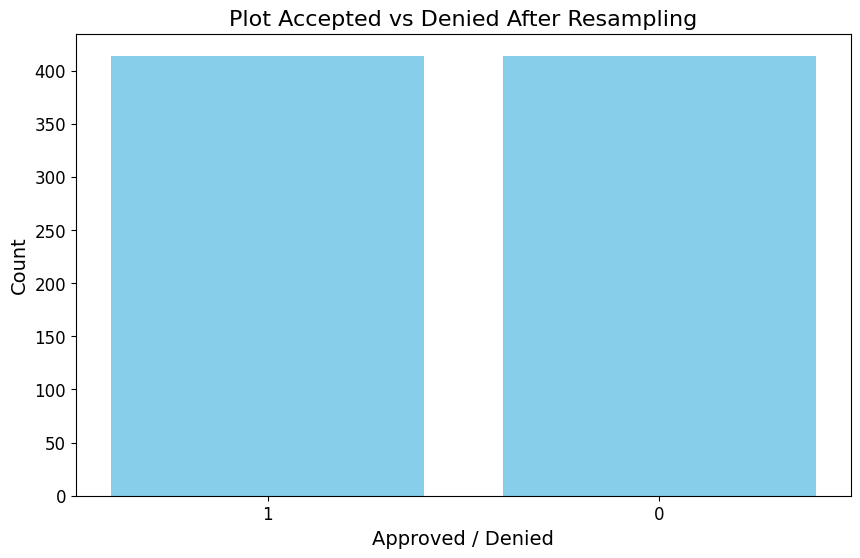

In [49]:
#plotting mismatch between approved and denied in the train data

bars = frequency_table_oversampled.index
height = frequency_table_oversampled.values
x_pos = range(len(bars))

plt.figure(figsize=(10, 6))
plt.bar(x_pos, height, color='skyblue')

plt.xticks(x_pos, bars, color='black', fontsize=12)
plt.yticks(color='black', fontsize=12)
plt.xlabel('Approved / Denied', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Plot Accepted vs Denied After Resampling', fontsize=16)

plt.show()

The dataset is now even between approved and denied requests.

I'm now going to fit the model once again and see if this leads to better results.

In [50]:
train_oversampled

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1
5,5417,4196.0,267.000000,360.0,1.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36,1828,1330.0,100.000000,342.0,0.0,0,1,0,0,1,0
168,2237,0.0,63.000000,480.0,0.0,1,0,0,1,0,0
328,4333,2451.0,110.000000,360.0,1.0,0,1,0,0,1,0
22,2600,1911.0,116.000000,360.0,0.0,0,1,0,1,0,0


In [51]:
scaler = StandardScaler()
X = train_oversampled.drop(columns='loan_Y')
y = train_oversampled['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


oversampled_model = LogisticRegression()

oversampled_model.fit(X_train_scaled, y_train)

print("train data length: ", len(X_train_scaled))
print("test data length", len(X_test_scaled))


train data length:  662
test data length 166


In [52]:
predictions_oversampled = oversampled_model.predict(X_test_scaled)

predictions_oversampled

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1])

In [53]:
predictions_oversampled_df = X_test.copy()

predictions_oversampled_df['loan_Y'] = predictions_oversampled

predictions_oversampled_df['actual_loan_Y'] = y_test

predictions_oversampled_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y,actual_loan_Y
597,2987,0.0,88.000000,360.0,0.0,1,0,0,1,0,0,0
52,4230,0.0,112.000000,360.0,1.0,1,0,0,1,0,1,0
429,2717,0.0,60.000000,180.0,1.0,1,0,0,0,1,1,1
524,4680,2087.0,146.412162,360.0,1.0,1,0,0,1,0,1,0
252,2583,2167.0,104.000000,360.0,1.0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
417,1600,20000.0,239.000000,360.0,1.0,0,1,0,0,1,1,0
285,3158,3053.0,89.000000,360.0,1.0,1,0,1,0,0,0,1
527,5285,1430.0,161.000000,360.0,0.0,0,1,0,1,0,0,1
396,3180,0.0,71.000000,360.0,0.0,1,0,0,0,1,0,0


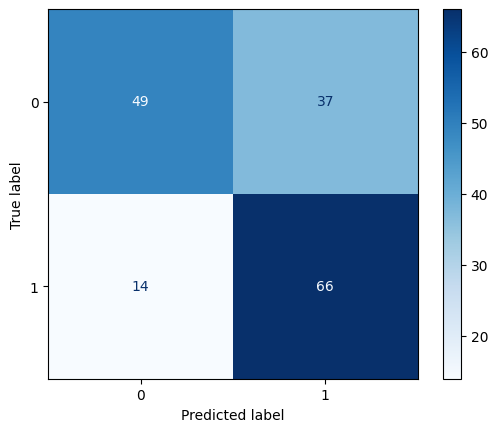

In [54]:
y_true = predictions_oversampled_df['actual_loan_Y']
y_pred = predictions_oversampled_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [55]:
print(classification_report(y_test, predictions_oversampled))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        86
           1       0.64      0.82      0.72        80

    accuracy                           0.69       166
   macro avg       0.71      0.70      0.69       166
weighted avg       0.71      0.69      0.69       166



After resampling the denied requests the model has improved on the denial requests but became worse on the approvals.

I'm going to try and work on the hyperparameters to see if this can simply be improved by tweaking the model or if further feature engineering needs to be pursued.

In [56]:
#introducing hyperparameters tweaking to improve model performance

hyperparameter_model = LogisticRegression(max_iter=500, solver='liblinear')

hyperparameter_model.fit(X_train_scaled, y_train)

predictions_hyperparameter = hyperparameter_model.predict(X_test_scaled)

In [57]:
predictions_hyperparameter_df = X_test.copy()

predictions_hyperparameter_df['loan_Y'] = predictions_hyperparameter

predictions_hyperparameter_df['actual_loan_Y'] = y_test

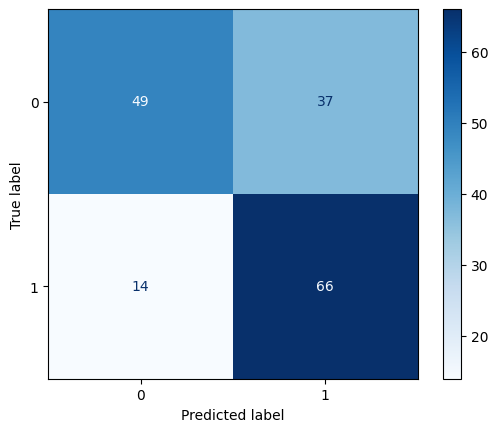

In [58]:
y_true = predictions_hyperparameter_df['actual_loan_Y']
y_pred = predictions_hyperparameter_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [59]:
print(classification_report(y_test, predictions_hyperparameter))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        86
           1       0.64      0.82      0.72        80

    accuracy                           0.69       166
   macro avg       0.71      0.70      0.69       166
weighted avg       0.71      0.69      0.69       166



Hyperparameters tuning hasn't lead to any improvement.

Considering that the relationship between the features and the target might not be linear I will use different models which perform better on different distributions of the data.

In [60]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

tree_baseline_model = DecisionTreeClassifier()

tree_baseline_model.fit(X_train_scaled, y_train) #fitting the model

DecisionTreeClassifier()

In [61]:
predictions_tree_baseline = tree_baseline_model.predict(X_test_scaled) #running predictions

predictions_tree_df = X_test.copy()

predictions_tree_df['loan_Y'] = predictions_tree_baseline #casting the predictions onto the df

predictions_tree_df['actual_loan_Y'] = y_test 

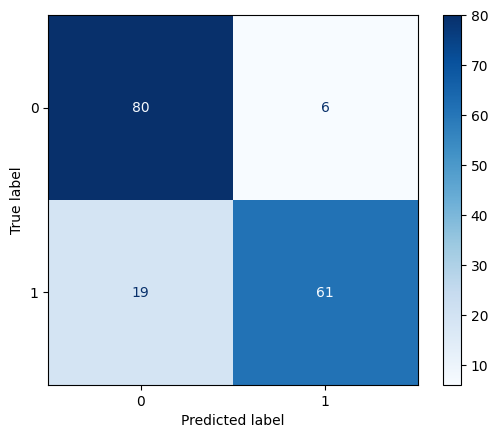

In [62]:
#creating the confusion matrix

y_true = predictions_tree_df['actual_loan_Y']
y_pred = predictions_tree_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [63]:
print(classification_report(y_test, predictions_tree_baseline))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86        86
           1       0.91      0.76      0.83        80

    accuracy                           0.85       166
   macro avg       0.86      0.85      0.85       166
weighted avg       0.86      0.85      0.85       166



The Decision Tree model leads to exciting results without any particular feature engineering or hyperparameter tuning.

The model is able to correctly predict 81% of the denied requests and 92% of the approved requests.

I'm going to apply hyperparameters tuning and see I can improve the performance even more.

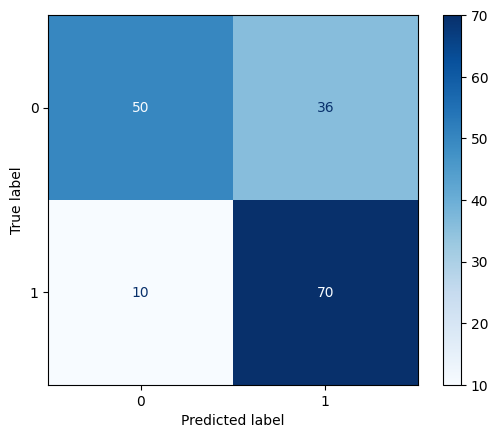

In [64]:
#Decision Tree

tree_hyperparameter = DecisionTreeClassifier(splitter='random',max_depth=5,max_features=3) #applying hyperparameters tuning

tree_hyperparameter.fit(X_train_scaled, y_train) #fitting the model

predictions_tree_hyperparameter = tree_hyperparameter.predict(X_test_scaled) #running predictions

predictions_treehyperpar_df = X_test.copy()

predictions_treehyperpar_df['loan_Y'] = predictions_tree_hyperparameter #casting the predictions onto the df

predictions_treehyperpar_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_treehyperpar_df['actual_loan_Y']
y_pred = predictions_treehyperpar_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [65]:
print(classification_report(y_test, predictions_tree_hyperparameter))

              precision    recall  f1-score   support

           0       0.83      0.58      0.68        86
           1       0.66      0.88      0.75        80

    accuracy                           0.72       166
   macro avg       0.75      0.73      0.72       166
weighted avg       0.75      0.72      0.72       166


Hyperparameter tuning has led to worseing of the results.

I'm going to proceed and test different models.

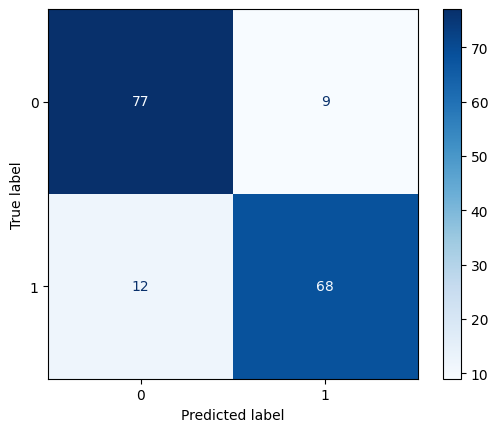

In [66]:
#Decision Tree

from sklearn.ensemble import RandomForestClassifier 

forest_baseline = RandomForestClassifier()

forest_baseline.fit(X_train_scaled, y_train) #fitting the model

predictions_forest_baseline = forest_baseline.predict(X_test_scaled) #running predictions

predictions_forest_df = X_test.copy()

predictions_forest_df['loan_Y'] = predictions_forest_baseline #casting the predictions onto the df

predictions_forest_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_forest_df['actual_loan_Y']
y_pred = predictions_forest_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [67]:
print(classification_report(y_test, predictions_forest_baseline))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        86
           1       0.88      0.85      0.87        80

    accuracy                           0.87       166
   macro avg       0.87      0.87      0.87       166
weighted avg       0.87      0.87      0.87       166



In [68]:
#implementing GridSearch to find the best parameters

from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth' : range(1, 30)}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

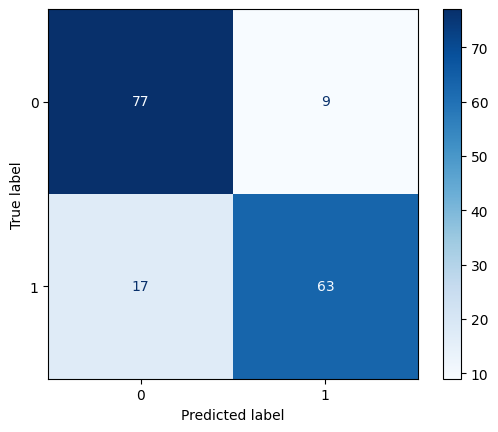

In [69]:
#RandomForest hyperparameter tuning with GridSearch

predictions_forest_hyper = best_model.predict(X_test_scaled) #running predictions

predictions_forest_hyper_df = X_test.copy()

predictions_forest_hyper_df['loan_Y'] = predictions_forest_hyper #casting the predictions onto the df

predictions_forest_hyper_df['actual_loan_Y'] = y_test 

#creating the confusion matrix

y_true = predictions_forest_hyper_df['actual_loan_Y']
y_pred = predictions_forest_hyper_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [70]:
print(classification_report(y_test, predictions_forest_hyper))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        86
           1       0.88      0.79      0.83        80

    accuracy                           0.84       166
   macro avg       0.85      0.84      0.84       166
weighted avg       0.85      0.84      0.84       166



The implementation of GridSearch has led to quick resolution of the hyperparameters.
The model selected has reached peaked when selecting a max_depth of 20 leading to a 85% precision on the denied requests and 89% on the approved requests, the best result reached so far.

I'm now going to test XGB to compare it with the RandomForest.

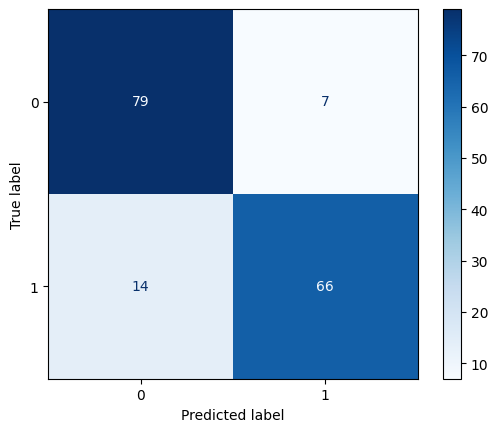

In [71]:
from xgboost import XGBClassifier


xgb_baseline = XGBClassifier()

xgb_baseline.fit(X_train_scaled, y_train)

xgb_baseline_predictions = xgb_baseline.predict(X_test_scaled)

xgb_baseline_df = X_test.copy()

xgb_baseline_df['loan_Y'] = xgb_baseline_predictions

xgb_baseline_df['actual_loan_Y'] = y_test

#creating the confusion matrix

y_true = xgb_baseline_df['actual_loan_Y']
y_pred = xgb_baseline_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [72]:
print(classification_report(y_test, xgb_baseline_predictions))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        86
           1       0.90      0.82      0.86        80

    accuracy                           0.87       166
   macro avg       0.88      0.87      0.87       166
weighted avg       0.88      0.87      0.87       166



XGB reaches the same level of accuracy of RandomForest without hyperparameter tuning.

I'm going to aplly GridSearch once again and see if this can improved.

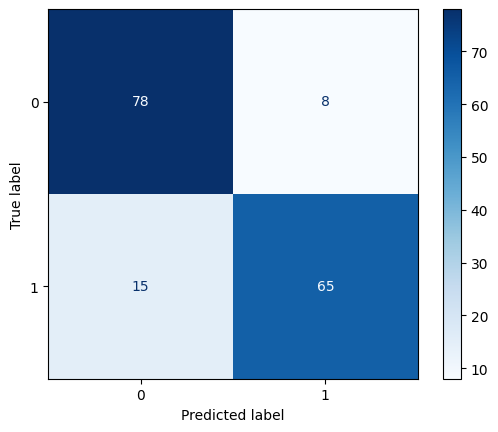

In [73]:
#implementing GridSearch to find the best parameters

param_grid = {'max_depth' : range(1, 30)}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5)

grid_search.fit(X_train_scaled, y_train)

best_xgbmodel = grid_search.best_estimator_

best_xgbmodel.fit(X_train_scaled, y_train)

xgb_hyper_predictions = best_xgbmodel.predict(X_test_scaled)

xgb_hyper_df = X_test.copy()

xgb_hyper_df['loan_Y'] = xgb_hyper_predictions

xgb_hyper_df['actual_loan_Y'] = y_test

#creating the confusion matrix

y_true = xgb_hyper_df['actual_loan_Y']
y_pred = xgb_hyper_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [74]:
print(classification_report(y_test, xgb_hyper_predictions))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        86
           1       0.89      0.81      0.85        80

    accuracy                           0.86       166
   macro avg       0.86      0.86      0.86       166
weighted avg       0.86      0.86      0.86       166



The XGBClassifier model performs equally even with hyperparameters tuning.

Since I reached a good level of performance I'm satisfied with what I achieved.

One last thing I'd like to try out is feature engineering and bringing the df to its extremes before running the XGBClassifier model one more time.

In [75]:
train_multi_colli = train_oversampled.copy()

In [76]:
#combining applicant income with co applicant income

train_multi_colli['tot_income'] = (train_multi_colli['applicantincome'] + train_multi_colli['coapplicantincome'])
train_multi_colli['tot_income']

0      5849.0
2      3000.0
3      4941.0
4      6000.0
5      9613.0
        ...  
36     3158.0
168    2237.0
328    6784.0
22     4511.0
166    4583.0
Name: tot_income, Length: 828, dtype: float64

In [77]:
#dropping applicant income and coapplicant income as well as credit history and loan amount term and married_N

train_multi_colli = train_multi_colli.drop(columns=['applicantincome', 'coapplicantincome', 'credit_history', 'loan_amount_term', 'married_No'])

train_multi_colli

,loanamount,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income
0,146.412162,0,0,0,1,1,5849.0
2,66.000000,1,0,0,1,1,3000.0
3,120.000000,1,0,0,1,1,4941.0
4,141.000000,0,0,0,1,1,6000.0
5,267.000000,1,0,0,1,1,9613.0
...,...,...,...,...,...,...,...
36,100.000000,1,0,0,1,0,3158.0
168,63.000000,0,0,1,0,0,2237.0
328,110.000000,1,0,0,1,0,6784.0
22,116.000000,1,0,1,0,0,4511.0


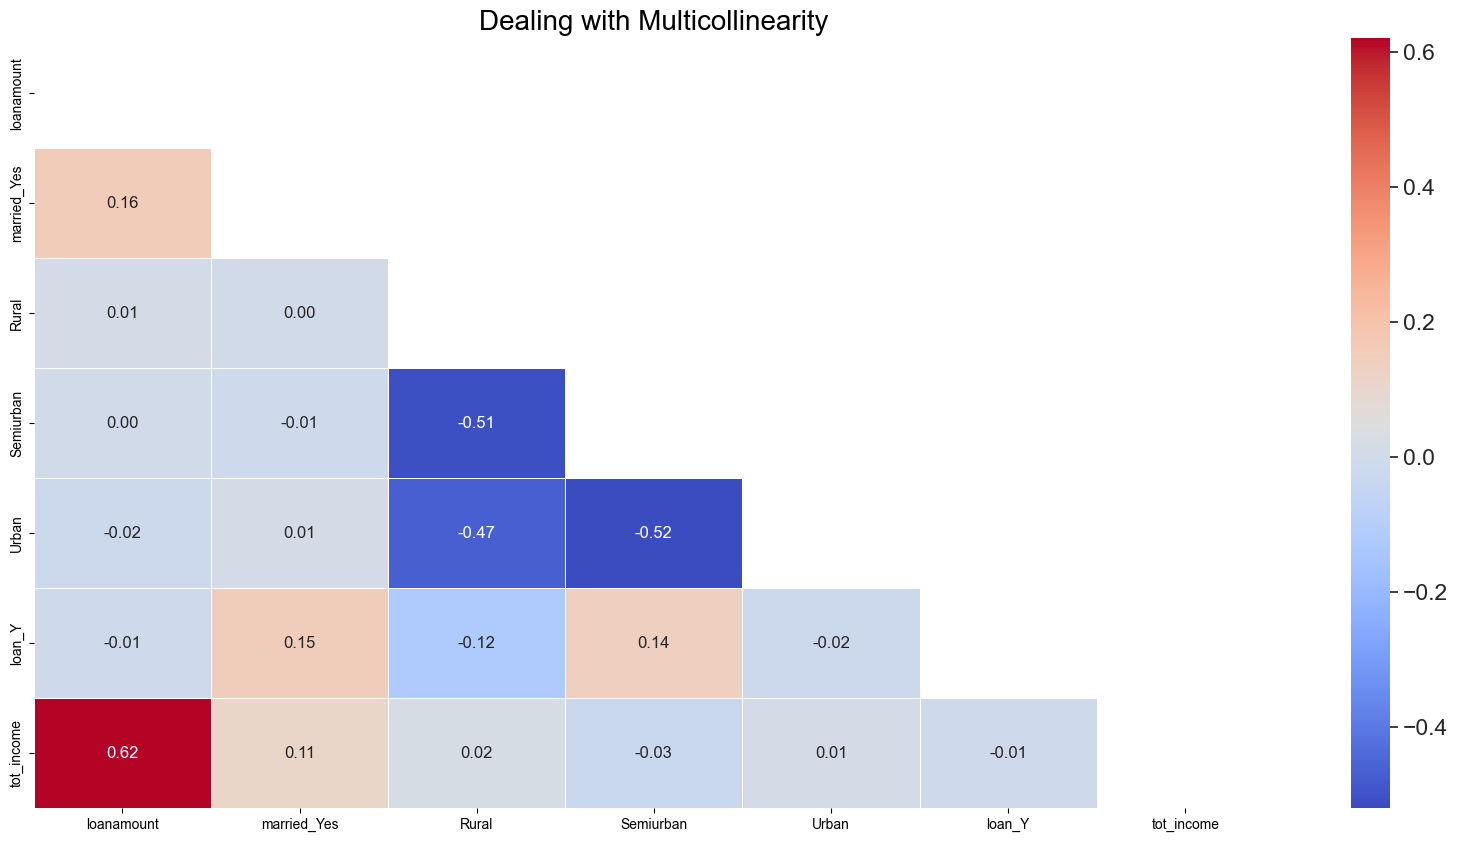

In [78]:
num_corr = round(train_multi_colli.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()


Based on the correlation matrix, I'm going to remove the loan_amount feature to avoid multicollinearity.

In [79]:
train_multi_colli = train_multi_colli.drop(columns='loanamount')

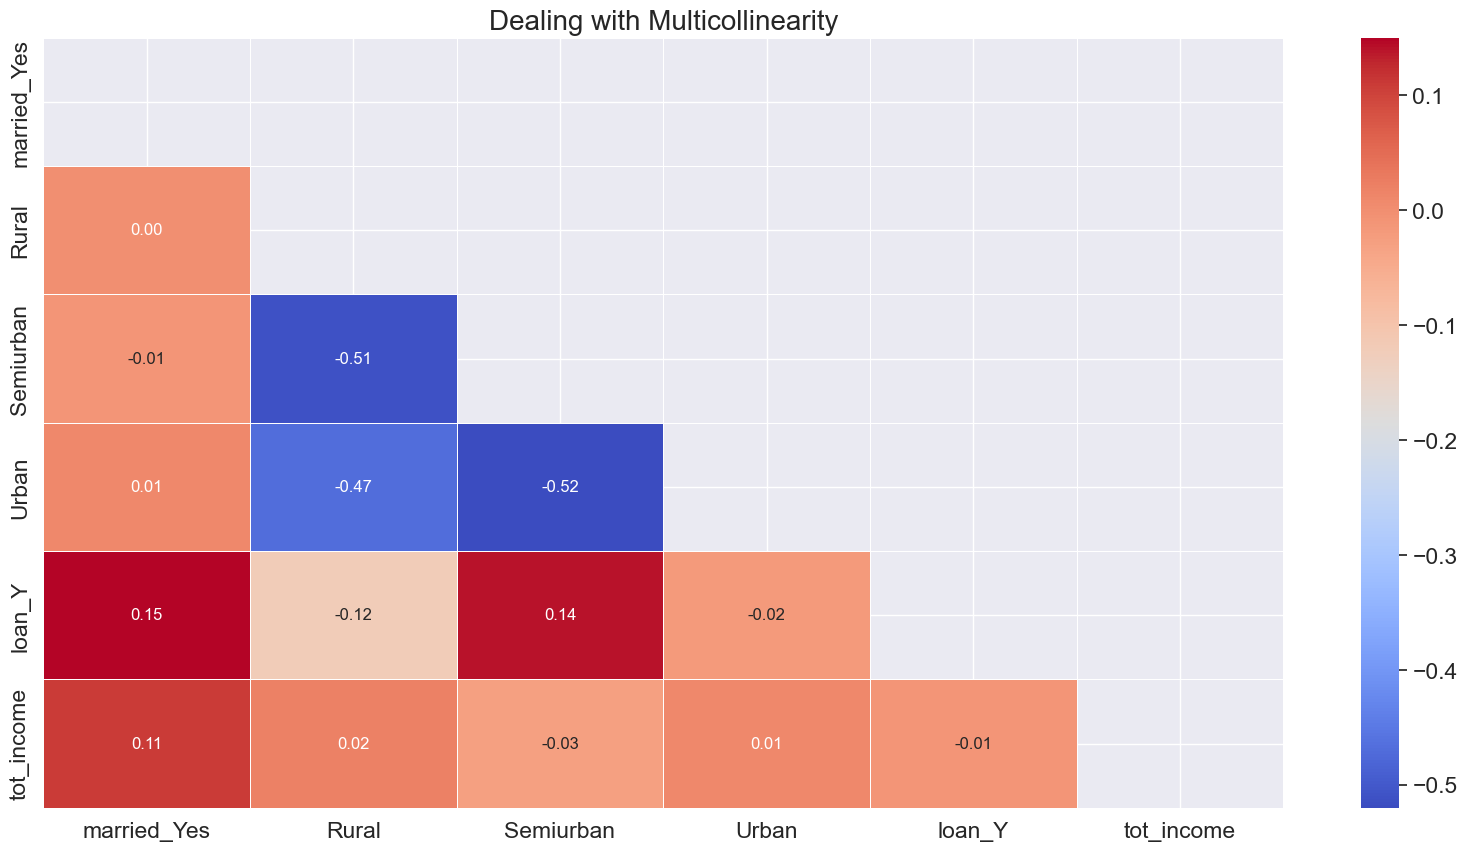

In [80]:
num_corr = round(train_multi_colli.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()


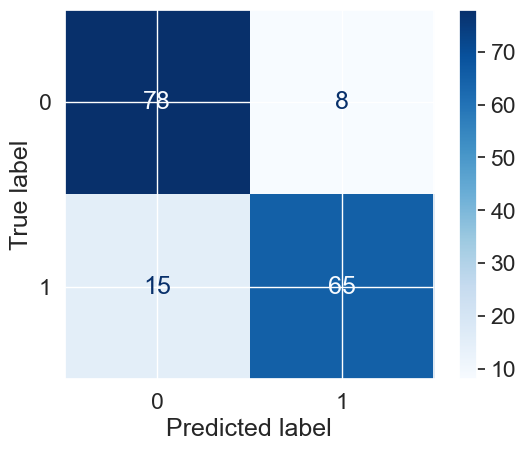

In [81]:
scaler = StandardScaler()
X = train_multi_colli.drop(columns='loan_Y')
y = train_multi_colli['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


xgb_feature_eng = XGBClassifier()

xgb_feature_eng.fit(X_train_scaled, y_train)

xgb_feature_predictions = xgb_feature_eng.predict(X_test_scaled)

xgb_feature_df = X_test.copy()

xgb_feature_df['loan_Y'] = xgb_hyper_predictions

xgb_feature_df['actual_loan_Y'] = y_test

#creating the confusion matrix

y_true = xgb_feature_df['actual_loan_Y']
y_pred = xgb_feature_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [82]:
print(classification_report(y_test, xgb_feature_predictions))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        86
           1       0.78      0.66      0.72        80

    accuracy                           0.75       166
   macro avg       0.75      0.74      0.74       166
weighted avg       0.75      0.75      0.74       166



In [83]:
#showing the performance of all of the models created

print("XGBClassifier Baseline Model Performance: \n", classification_report(y_test, xgb_baseline_predictions))
print("XGBClassifier Hyperparameter tuning Model Performance: \n", classification_report(y_test, xgb_hyper_predictions))
print("XGBClassifier Feature Engineering Model Performance: \n", classification_report(y_test, xgb_feature_predictions))

XGBClassifier Baseline Model Performance: 
               precision    recall  f1-score   support

           0       0.85      0.92      0.88        86
           1       0.90      0.82      0.86        80

    accuracy                           0.87       166
   macro avg       0.88      0.87      0.87       166
weighted avg       0.88      0.87      0.87       166

XGBClassifier Hyperparameter tuning Model Performance: 
               precision    recall  f1-score   support

           0       0.84      0.91      0.87        86
           1       0.89      0.81      0.85        80

    accuracy                           0.86       166
   macro avg       0.86      0.86      0.86       166
weighted avg       0.86      0.86      0.86       166

XGBClassifier Feature Engineering Model Performance: 
               precision    recall  f1-score   support

           0       0.72      0.83      0.77        86
           1       0.78      0.66      0.72        80

    accuracy              

In [84]:
#saving the performing model

#import pickle

#pickle.dump(xgb_baseline, open("Home_loan_xgb_model.sav", 'wb'))

In [85]:
#to load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

In [86]:
unseen_df = test.copy()

In [87]:
final_test_prediction = xgb_baseline.predict(unseen_df)

unseen_df['loan_Y'] = final_test_prediction

unseen_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5720,0,110.0,360.0,1.0,0,1,0,0,1,0
1,3076,1500,126.0,360.0,1.0,0,1,0,0,1,0
2,5000,1800,208.0,360.0,1.0,0,1,0,0,1,0
4,3276,0,78.0,360.0,1.0,1,0,0,0,1,0
5,2165,3422,152.0,360.0,1.0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
361,2269,2167,99.0,360.0,1.0,0,1,0,1,0,0
362,4009,1777,113.0,360.0,1.0,0,1,0,0,1,0
363,4158,709,115.0,360.0,1.0,0,1,0,0,1,0
365,5000,2393,158.0,360.0,1.0,0,1,1,0,0,0


In [88]:
unseen_df['loan_Y'].value_counts()

loan_Y
0    252
1     47
Name: count, dtype: int64

The result of the final test show a worrying result as the majority of the requests have been denied.

This might be a signal that the XGBClassifier model is overfitted.

I'm going to test the rest of the XGB models to see if the results are similar.

In [89]:
unseen_df2 = unseen_df.copy()

unseen_df2 = unseen_df2.drop(columns='loan_Y')

final_test_prediction2 = best_xgbmodel.predict(unseen_df2)

unseen_df2['loan_Y'] = final_test_prediction2

unseen_df2['loan_Y'].value_counts()

loan_Y
0    251
1     48
Name: count, dtype: int64

In [90]:
unseen_df3 = unseen_df.copy()

unseen_df3 = unseen_df3.drop(columns='loan_Y')

final_test_prediction3 = forest_baseline.predict(unseen_df3)

unseen_df3['loan_Y'] = final_test_prediction3

unseen_df3['loan_Y'].value_counts()

c:\Data_Science\IH_Notebooks\home_loan_approval\home_loan\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


loan_Y
0    215
1     84
Name: count, dtype: int64

In [91]:
from sklearn.model_selection import cross_val_score

cross_val_score(xgb_baseline, X, y, cv=5)

array([0.77108434, 0.6746988 , 0.72891566, 0.72727273, 0.67878788])

In [92]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_xgbmodel, X, y, cv=5)

print(f"Mean accuracy: {scores.mean():.2f}, Std: {scores.std():.2f}")

Mean accuracy: 0.73, Std: 0.02


After cross validation I can confirm the model performs an average of 73% precision on different test splits.

This is not a bad performance but there is still room for improvement.

As the model was already generated with GridSearch no further hyperparameter tuning is going to be applied but I'll go back on feature engineering.

In [93]:
feature_engineering_df = train_oversampled.copy()
feature_engineering_df

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history,married_No,married_Yes,Rural,Semiurban,Urban,loan_Y
0,5849,0.0,146.412162,360.0,1.0,1,0,0,0,1,1
2,3000,0.0,66.000000,360.0,1.0,0,1,0,0,1,1
3,2583,2358.0,120.000000,360.0,1.0,0,1,0,0,1,1
4,6000,0.0,141.000000,360.0,1.0,1,0,0,0,1,1
5,5417,4196.0,267.000000,360.0,1.0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
36,1828,1330.0,100.000000,342.0,0.0,0,1,0,0,1,0
168,2237,0.0,63.000000,480.0,0.0,1,0,0,1,0,0
328,4333,2451.0,110.000000,360.0,1.0,0,1,0,0,1,0
22,2600,1911.0,116.000000,360.0,0.0,0,1,0,1,0,0


In [94]:
feature_engineering_df['loanamount'] = feature_engineering_df['loanamount'] * 1000

feature_engineering_df['tot_income'] = (feature_engineering_df['applicantincome'] + feature_engineering_df['coapplicantincome'])

feature_engineering_df = feature_engineering_df.drop(columns=['married_No', 'applicantincome', 'coapplicantincome', 'credit_history'])

feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income
0,146412.162162,360.0,0,0,0,1,1,5849.0
2,66000.000000,360.0,1,0,0,1,1,3000.0
3,120000.000000,360.0,1,0,0,1,1,4941.0
4,141000.000000,360.0,0,0,0,1,1,6000.0
5,267000.000000,360.0,1,0,0,1,1,9613.0
...,...,...,...,...,...,...,...,...
36,100000.000000,342.0,1,0,0,1,0,3158.0
168,63000.000000,480.0,0,0,1,0,0,2237.0
328,110000.000000,360.0,1,0,0,1,0,6784.0
22,116000.000000,360.0,1,0,1,0,0,4511.0


In [95]:
feature_engineering_df['income_to_loan_ratio'] = (feature_engineering_df['tot_income'] / feature_engineering_df['loanamount'])
feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income,income_to_loan_ratio
0,146412.162162,360.0,0,0,0,1,1,5849.0,0.039949
2,66000.000000,360.0,1,0,0,1,1,3000.0,0.045455
3,120000.000000,360.0,1,0,0,1,1,4941.0,0.041175
4,141000.000000,360.0,0,0,0,1,1,6000.0,0.042553
5,267000.000000,360.0,1,0,0,1,1,9613.0,0.036004
...,...,...,...,...,...,...,...,...,...
36,100000.000000,342.0,1,0,0,1,0,3158.0,0.031580
168,63000.000000,480.0,0,0,1,0,0,2237.0,0.035508
328,110000.000000,360.0,1,0,0,1,0,6784.0,0.061673
22,116000.000000,360.0,1,0,1,0,0,4511.0,0.038888


In [96]:
feature_engineering_df['loan_term_years'] = (feature_engineering_df['loan_amount_term'] / 12)
feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income,income_to_loan_ratio,loan_term_years
0,146412.162162,360.0,0,0,0,1,1,5849.0,0.039949,30.0
2,66000.000000,360.0,1,0,0,1,1,3000.0,0.045455,30.0
3,120000.000000,360.0,1,0,0,1,1,4941.0,0.041175,30.0
4,141000.000000,360.0,0,0,0,1,1,6000.0,0.042553,30.0
5,267000.000000,360.0,1,0,0,1,1,9613.0,0.036004,30.0
...,...,...,...,...,...,...,...,...,...,...
36,100000.000000,342.0,1,0,0,1,0,3158.0,0.031580,28.5
168,63000.000000,480.0,0,0,1,0,0,2237.0,0.035508,40.0
328,110000.000000,360.0,1,0,0,1,0,6784.0,0.061673,30.0
22,116000.000000,360.0,1,0,1,0,0,4511.0,0.038888,30.0


In [97]:
monthly_payment = (feature_engineering_df['loanamount'] / feature_engineering_df['loan_amount_term'])
monthly_payment

0      406.700450
2      183.333333
3      333.333333
4      391.666667
5      741.666667
          ...    
36     292.397661
168    131.250000
328    305.555556
22     322.222222
166    311.111111
Length: 828, dtype: float64

In [98]:
feature_engineering_df['monthly_payment'] = (feature_engineering_df['loanamount'] / feature_engineering_df['loan_amount_term'])
feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income,income_to_loan_ratio,loan_term_years,monthly_payment
0,146412.162162,360.0,0,0,0,1,1,5849.0,0.039949,30.0,406.700450
2,66000.000000,360.0,1,0,0,1,1,3000.0,0.045455,30.0,183.333333
3,120000.000000,360.0,1,0,0,1,1,4941.0,0.041175,30.0,333.333333
4,141000.000000,360.0,0,0,0,1,1,6000.0,0.042553,30.0,391.666667
5,267000.000000,360.0,1,0,0,1,1,9613.0,0.036004,30.0,741.666667
...,...,...,...,...,...,...,...,...,...,...,...
36,100000.000000,342.0,1,0,0,1,0,3158.0,0.031580,28.5,292.397661
168,63000.000000,480.0,0,0,1,0,0,2237.0,0.035508,40.0,131.250000
328,110000.000000,360.0,1,0,0,1,0,6784.0,0.061673,30.0,305.555556
22,116000.000000,360.0,1,0,1,0,0,4511.0,0.038888,30.0,322.222222


In [99]:
feature_engineering_df['monthly_payment'] = round(feature_engineering_df['monthly_payment'], 2)

In [102]:
feature_engineering_df['loanamount'] = round(feature_engineering_df['loanamount'], 0)
feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,loan_Y,tot_income,income_to_loan_ratio,loan_term_years,monthly_payment
0,146412.0,360.0,0,0,0,1,1,5849.0,0.039949,30.0,406.70
2,66000.0,360.0,1,0,0,1,1,3000.0,0.045455,30.0,183.33
3,120000.0,360.0,1,0,0,1,1,4941.0,0.041175,30.0,333.33
4,141000.0,360.0,0,0,0,1,1,6000.0,0.042553,30.0,391.67
5,267000.0,360.0,1,0,0,1,1,9613.0,0.036004,30.0,741.67
...,...,...,...,...,...,...,...,...,...,...,...
36,100000.0,342.0,1,0,0,1,0,3158.0,0.031580,28.5,292.40
168,63000.0,480.0,0,0,1,0,0,2237.0,0.035508,40.0,131.25
328,110000.0,360.0,1,0,0,1,0,6784.0,0.061673,30.0,305.56
22,116000.0,360.0,1,0,1,0,0,4511.0,0.038888,30.0,322.22


In [103]:
#moving the loan_Y on the right of the df

loan_y_col = feature_engineering_df.pop('loan_Y')
feature_engineering_df['loan_Y'] = loan_y_col

feature_engineering_df

,loanamount,loan_amount_term,married_Yes,Rural,Semiurban,Urban,tot_income,income_to_loan_ratio,loan_term_years,monthly_payment,loan_Y
0,146412.0,360.0,0,0,0,1,5849.0,0.039949,30.0,406.70,1
2,66000.0,360.0,1,0,0,1,3000.0,0.045455,30.0,183.33,1
3,120000.0,360.0,1,0,0,1,4941.0,0.041175,30.0,333.33,1
4,141000.0,360.0,0,0,0,1,6000.0,0.042553,30.0,391.67,1
5,267000.0,360.0,1,0,0,1,9613.0,0.036004,30.0,741.67,1
...,...,...,...,...,...,...,...,...,...,...,...
36,100000.0,342.0,1,0,0,1,3158.0,0.031580,28.5,292.40,0
168,63000.0,480.0,0,0,1,0,2237.0,0.035508,40.0,131.25,0
328,110000.0,360.0,1,0,0,1,6784.0,0.061673,30.0,305.56,0
22,116000.0,360.0,1,0,1,0,4511.0,0.038888,30.0,322.22,0


Now more features have been created from the features we had originally in the df.

I'm going to run the correlation process once again and define multicollinearity.

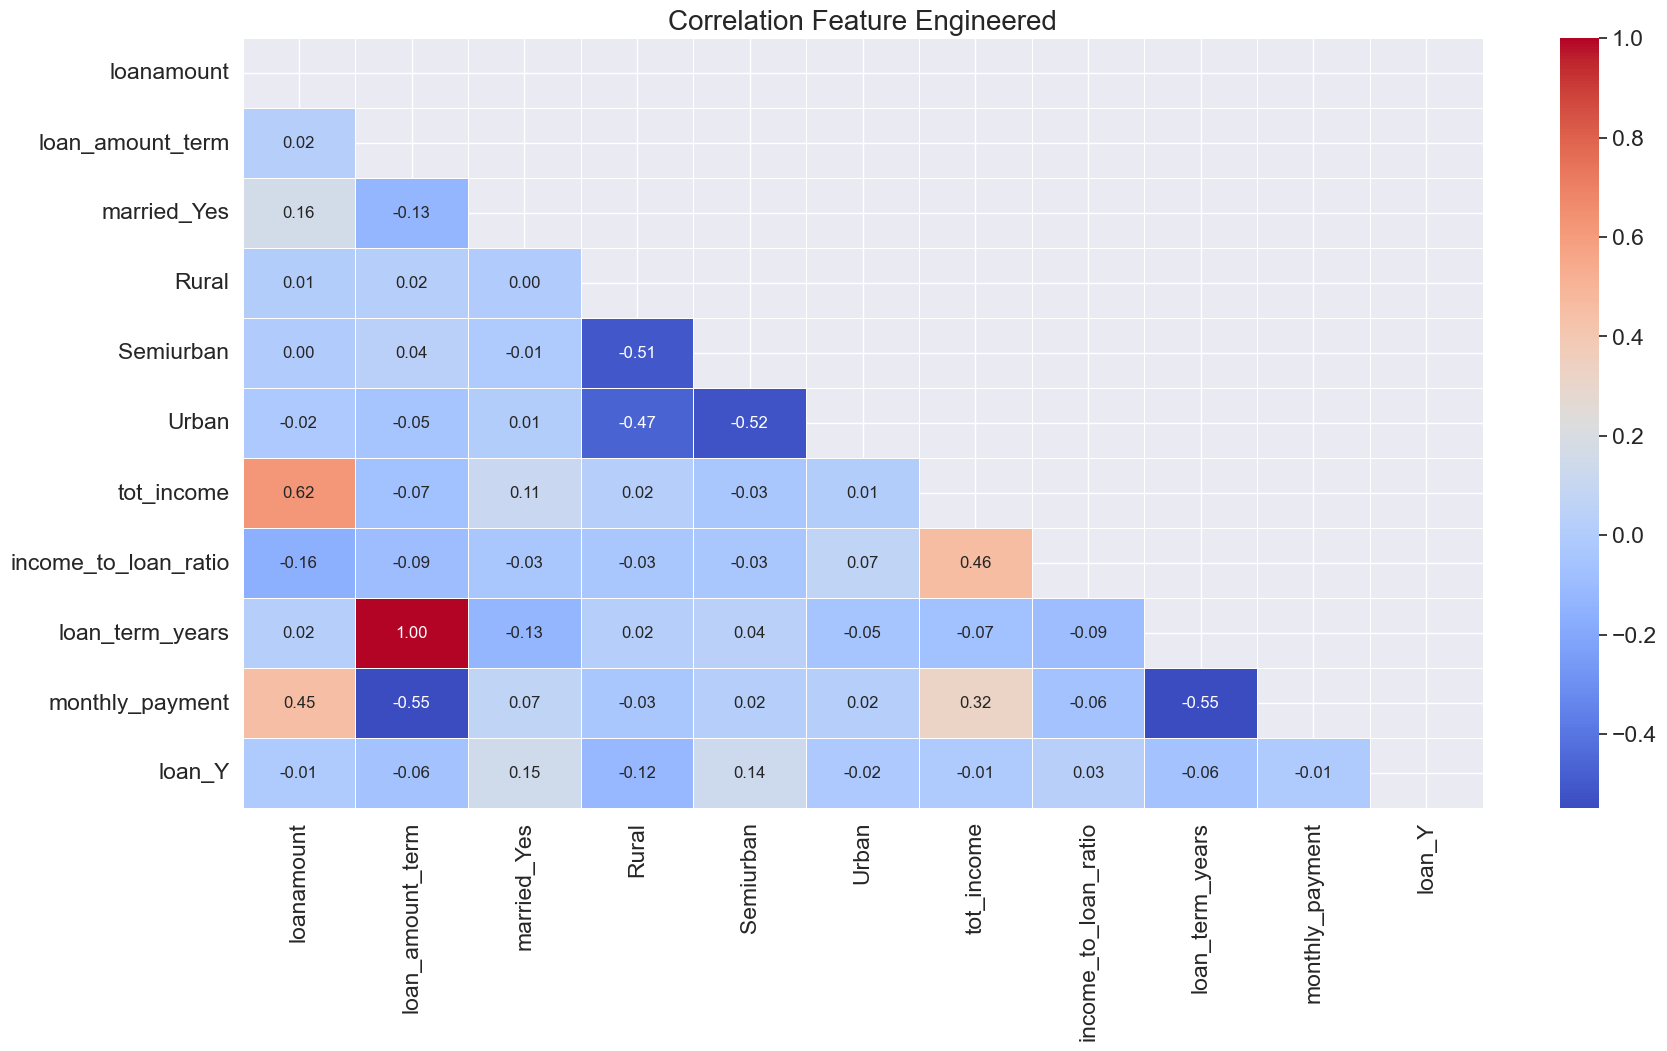

In [104]:
#correlation and multicollinearity check

num_corr = round(feature_engineering_df.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Feature Engineered", fontsize=20)
plt.show()


The following features have high correlation and will be removed to avoid multicollinearity:

- Rural
- Urban
- loanamount
- tot_income
- loan_amount_term
- monthly_payment

In [105]:
#creating a new df and keeping feature_engineering_df as a new baseline df

cleaned_df = feature_engineering_df.copy()

cleaned_df.columns = cleaned_df.columns.str.lower()

cleaned_df = cleaned_df.drop(columns=['rural', 'urban', 'loanamount','tot_income', 'loan_amount_term', 'monthly_payment'])

cleaned_df

,married_yes,semiurban,income_to_loan_ratio,loan_term_years,loan_y
0,0,0,0.039949,30.0,1
2,1,0,0.045455,30.0,1
3,1,0,0.041175,30.0,1
4,0,0,0.042553,30.0,1
5,1,0,0.036004,30.0,1
...,...,...,...,...,...
36,1,0,0.031580,28.5,0
168,0,1,0.035508,40.0,0
328,1,0,0.061673,30.0,0
22,1,1,0.038888,30.0,0


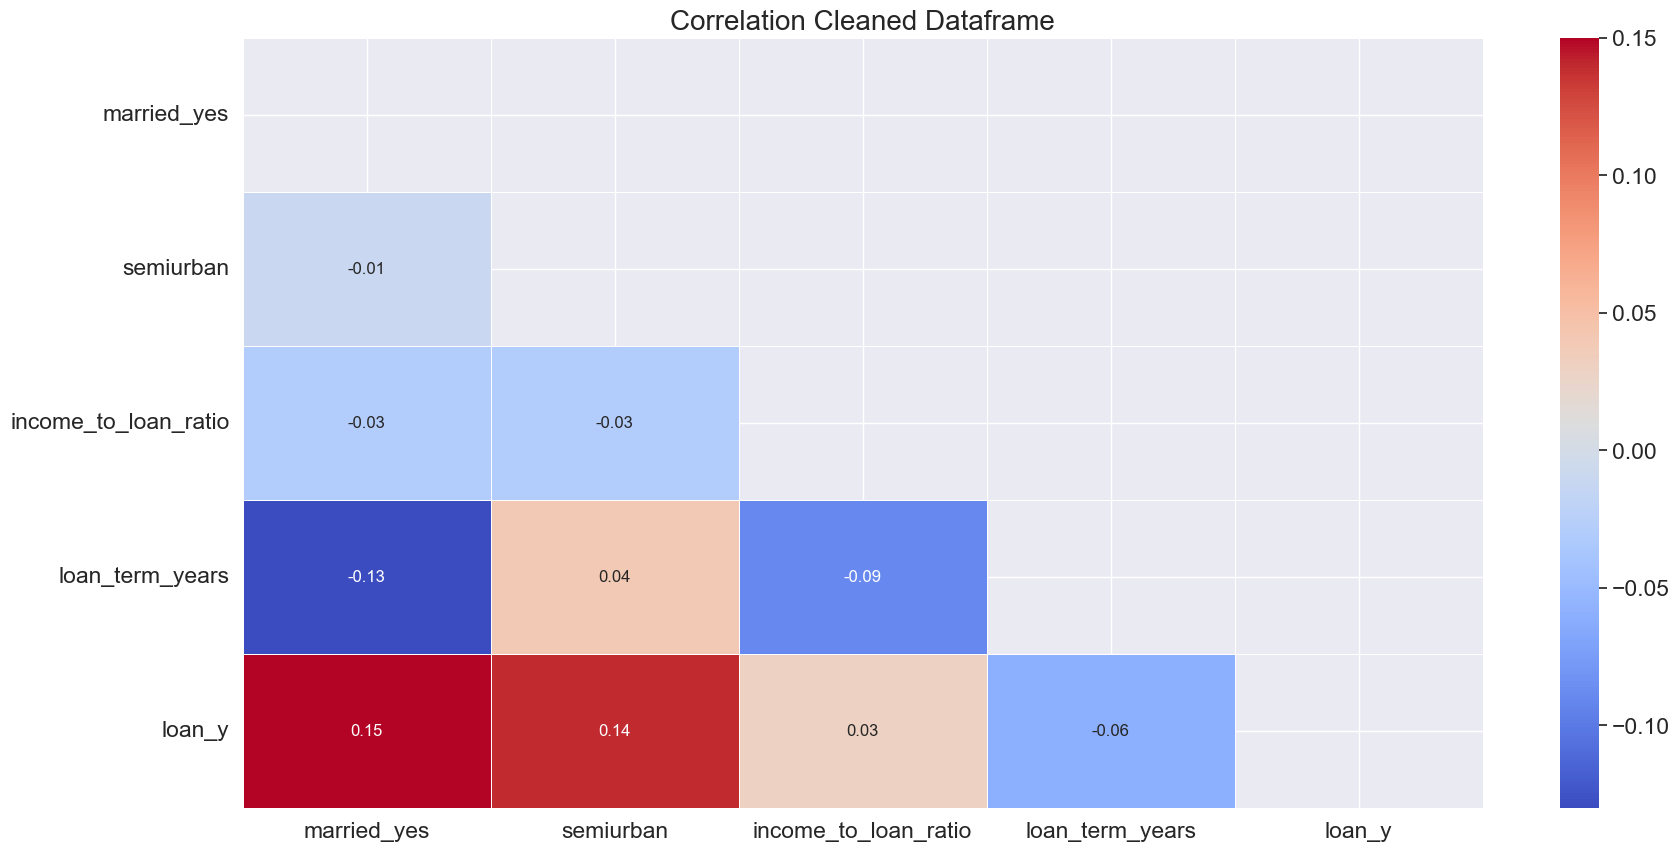

In [108]:
#correlation matrix for the cleaned_df

num_corr = round(cleaned_df.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5)

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation Cleaned Dataframe", fontsize=20)
plt.show()

In [ ]:
sclaer = StandardScaler()

X = cleaned_df.drop(columns='loan_y')
y = cleaned_df['loan_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



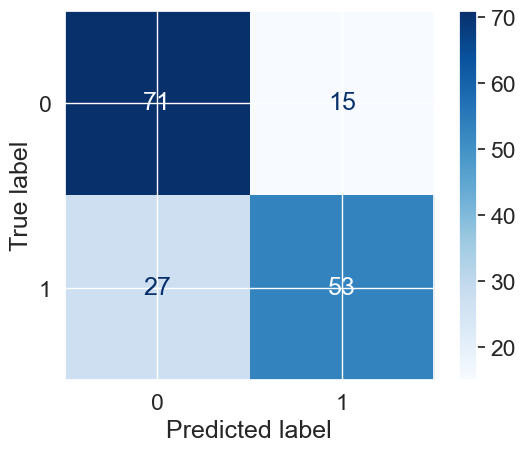

In [109]:
scaler = StandardScaler()
X = train_multi_colli.drop(columns='loan_Y')
y = train_multi_colli['loan_Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


xgb_cleaned = XGBClassifier()

xgb_cleaned.fit(X_train_scaled, y_train)

xgb_cleaned_predictions = xgb_cleaned.predict(X_test_scaled)

xgb_cleaned_df = X_test.copy()

xgb_cleaned_df['loan_Y'] = xgb_cleaned_predictions

xgb_cleaned_df['actual_loan_Y'] = y_test

#creating the confusion matrix

y_true = xgb_cleaned_df['actual_loan_Y']
y_pred = xgb_cleaned_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [110]:
scores = cross_val_score(xgb_cleaned, X, y, cv=5)

print(f"Mean accuracy: {scores.mean():.2f}, Std: {scores.std():.2f}")

Mean accuracy: 0.72, Std: 0.04


The newly created model performs as the best performance model tested previously on this notebook.

I'm going to go back to the feature_engineering_df and see if other columns might be added or dropped.

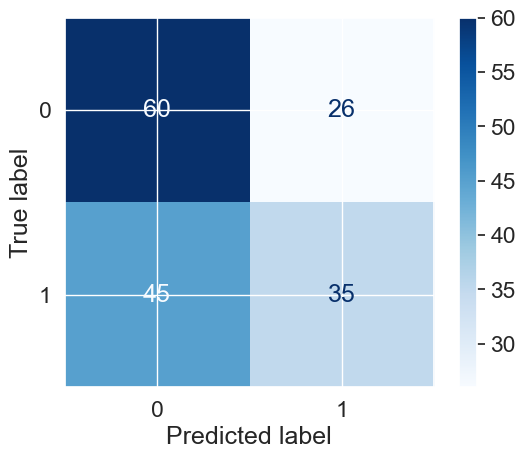

In [112]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(X_train_scaled, y_train)

svc_model_predictions = svc_model.predict(X_test_scaled)

svc_df = X_test.copy()

svc_df['loan_Y'] = svc_model_predictions
svc_df['actual_loan_Y'] = y_test

y_true = svc_df['actual_loan_Y']
y_pred = svc_df['loan_Y']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')

In [113]:
scores = cross_val_score(svc_model, X, y, cv=5)

print(f"Mean accuracy: {scores.mean():.2f}, Std: {scores.std():.2f}")

Mean accuracy: 0.53, Std: 0.03


Considering the models aren't performing better with feature engineering and hyperparameters tuning I'm going to go back to square 1 and deal with missing data in a different way.

In [138]:
new_df_train = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_train.csv')
new_df_test = pd.read_csv('c:/Data_Science/IH_Notebooks/home_loan_approval/loan_sanction_test.csv')

new_df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [139]:
#creating a function to deal with NA

def dealNA(data, cols=[], way='mode'):
    for col in cols:
        if way == 'mode':
            data[col] = data[col].fillna(data[col].mode()[0]) #to avoid issues as having more than 1 mode
        else:
            raise ValueError (f"Invalid method '{way}'. Please choose 'mode'. ")

In [140]:
dealNA(new_df_train, cols=['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History'], way='mode')
dealNA(new_df_test, cols=['Gender', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History'], way='mode')

The missing LoanAmount are going to be filled using the LinearRegression model to avoid to introduce bias in the data.

In [141]:
new_df_train.drop(columns='Loan_ID', inplace=True)
new_df_test.drop(columns='Loan_ID', inplace=True)

In [142]:
#Encoding via remapping

replace_dict = {
    "Gender" : {"Male" : 1, "Female" : 0},
    "Married" : {"Yes" : 1, "No" : 0},
    "Dependents" : {"3+": 4},
    "Education" : {"Graduate" : 1, "Not Graduate" : 0},
    "Self_Employed" : {"Yes" : 1, "No" : 0},
    "Property_Area" : {"Semiurban": 2, "Urban" : 1, "Rural": 0},
    "Loan_Status" : {"Y": 1, "N": 0}
}

new_df_train.replace(replace_dict, inplace=True)
new_df_test.replace(replace_dict, inplace=True)

C:\Users\Mirko\AppData\Local\Temp\ipykernel_14048\2904959861.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df_train.replace(replace_dict, inplace=True)
C:\Users\Mirko\AppData\Local\Temp\ipykernel_14048\2904959861.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df_test.replace(replace_dict, inplace=True)


In [143]:
#filling Na of LoanAmount with LinearRegression

def filling_loan_amount(df, target_col):
    from sklearn.linear_model import LinearRegression

    features = [col for col in df.columns if col != target_col] #defining the features without the target

    #splitting the data between rows with missing LoanAmount and not missing LoanAmount

    df_notnull = df[df[target_col].notnull()]
    df_null = df[df[target_col].isnull()]

    #Printing message if no missing values found in df_null
    if df_null.empty:
        print("No missing values found and no changes made")
        return df
    
    #preparing the X and y features

    X_train = df_notnull[features] #features already contains the columns needed without the target
    y_train = df_notnull[target_col]
    X_predict = df_null[features]

    model = LinearRegression()

    model.fit(X_train, y_train)

    predicted_values = model.predict(X_predict)

    #Filling the missing values

    df.loc[df[target_col].isnull(), target_col] = predicted_values #target_col after comma is fundamental to avoid to assign predicted_values to the whole row

    print("Missing values successfully filled with LinearRegression")
    return df

In [145]:
target = 'LoanAmount'

filling_loan_amount(new_df_train, target_col= target)
filling_loan_amount(new_df_test, target_col= target)

Missing values successfully filled with LinearRegression
Missing values successfully filled with LinearRegression


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,1,0,1,0,5720,0,110.0,360.0,1.0,1
1,1,1,1,1,0,3076,1500,126.0,360.0,1.0,1
2,1,1,2,1,0,5000,1800,208.0,360.0,1.0,1
3,1,1,2,1,0,2340,2546,100.0,360.0,1.0,1
4,1,0,0,0,0,3276,0,78.0,360.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
362,1,1,4,0,1,4009,1777,113.0,360.0,1.0,1
363,1,1,0,1,0,4158,709,115.0,360.0,1.0,1
364,1,0,0,1,0,3250,1993,126.0,360.0,1.0,2
365,1,1,0,1,0,5000,2393,158.0,360.0,1.0,0


I will now train and test multiple models with a function.

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [155]:
def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Logistic Regression" : LogisticRegression(),
        "Random Forest" : RandomForestClassifier(),
        "XGB" : XGBClassifier()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    #scaling data just for LogisticRegression

    for name, model in models.items():
        if name in ['Logistic Regression']:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            print(f"Features scaled for model {name}")

        print(f"Training model: {name}")

        model.fit(X_train_scaled, y_train)

        y_train_predict = model.predict(X_train_scaled) #to test accuracy on the train dataframe
        y_test_predict = model.predict(X_test_scaled)

        results.append({
            "Model" : name,
            "Train Accuracy" : accuracy_score(y_train, y_train_predict),
            "Test Accuracy" : accuracy_score(y_test, y_test_predict),
            "Train Precision" : precision_score(y_train, y_train_predict),
            "Test Precision" : precision_score(y_test, y_test_predict),
            "Train F1 Score" : f1_score(y_train, y_train_predict),
            "Test F1 Score" : f1_score(y_test, y_test_predict)
        })

    #Convering result into a df
    results_df = pd.DataFrame(results)
    print("\n Model Performance Summary: ")
    print(results_df)
    

    return results_df

In [156]:
results_df = train_and_eval_models(X_train, X_test, y_train, y_test)

print(results_df)

Starting the training process.
Features scaled for model Logistic Regression
Training model: Logistic Regression
Training model: Random Forest
Training model: XGB

 Model Performance Summary: 
                 Model  Train Accuracy  Test Accuracy  Train Precision  \
0  Logistic Regression        0.602719       0.572289         0.621993   
1        Random Forest        0.992447       0.813253         0.991045   
2                  XGB        0.907855       0.746988         0.907463   

   Test Precision  Train F1 Score  Test F1 Score  
0        0.563380        0.579200       0.529801  
1        0.888889        0.992526       0.783217  
2        0.779412        0.908819       0.716216  
                 Model  Train Accuracy  Test Accuracy  Train Precision  \
0  Logistic Regression        0.602719       0.572289         0.621993   
1        Random Forest        0.992447       0.813253         0.991045   
2                  XGB        0.907855       0.746988         0.907463   

   Test P

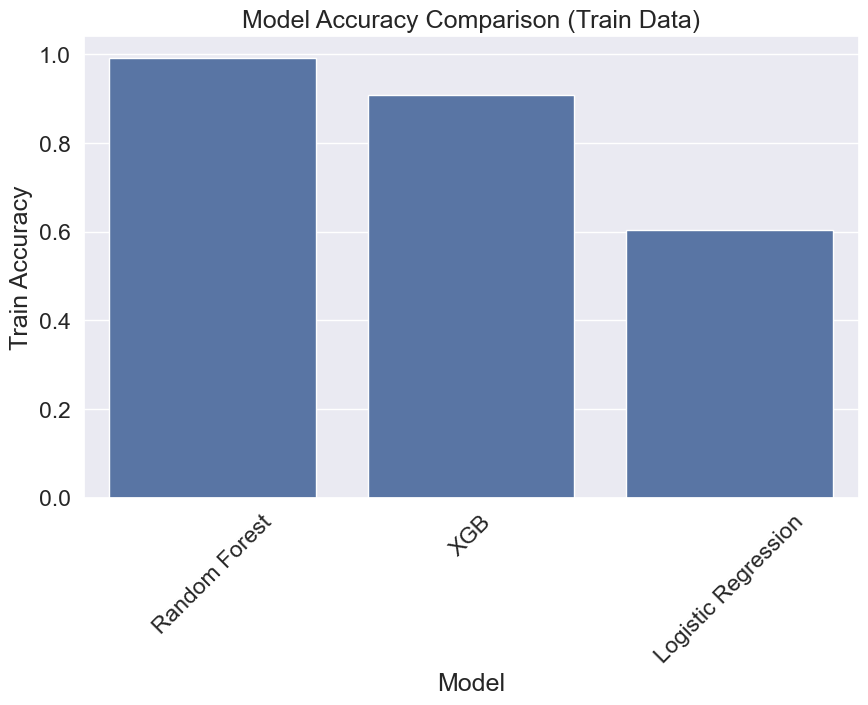

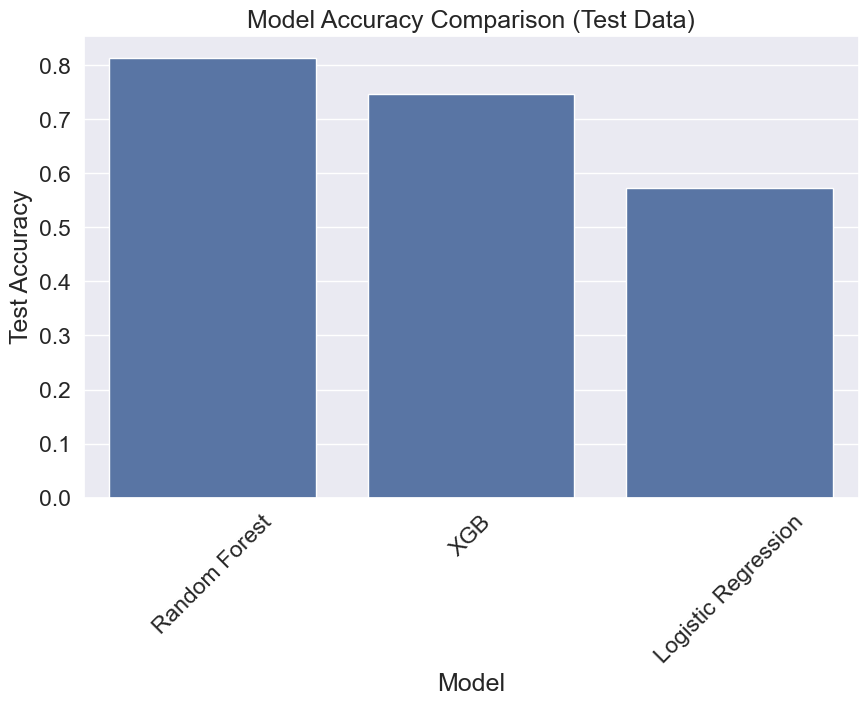

In [162]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train Accuracy", data=results_df.sort_values(by='Train Accuracy', ascending=False))
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test Accuracy", data=results_df.sort_values(by='Test Accuracy', ascending=False))
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()

In [163]:
#saving the best performing model

best_model = results_df.sort_values(by='Test Accuracy', ascending=False).iloc[0]['Model']
print("Best performing model on the test data is: ", best_model)

Best performing model on the test data is:  Random Forest


In [165]:
#saving the best model with pickle

import pickle

trained_models = {} #needed to store the trained models
results= []

models = {
    "Logistic Regression" : LogisticRegression(),
    "Random Forest" : RandomForestClassifier(),
    "XGB" : XGBClassifier()
}

for name, model in models.items():
    if name == "Logistic Regression":
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        X_train_used = X_train_scaled 
        X_test_used = X_test_scaled
    else:
        model.fit(X_train, y_train)
        X_train_used = X_train
        X_test_used = X_test

    trained_models[name] = model #key gets assigned the name of the model trained

y_train_predict = model.predict(X_train_used) #to test accuracy on the train dataframe
y_test_predict = model.predict(X_test_used)

results.append({
    "Model" : name,
    "Train Accuracy" : accuracy_score(y_train, y_train_predict),
    "Test Accuracy" : accuracy_score(y_test, y_test_predict),
    "Train Precision" : precision_score(y_train, y_train_predict),
    "Test Precision" : precision_score(y_test, y_test_predict),
    "Train F1 Score" : f1_score(y_train, y_train_predict),
    "Test F1 Score" : f1_score(y_test, y_test_predict)
        })

results_df = pd.DataFrame(results)

best_model_name = results_df.sort_values(by='Test Accuracy', ascending=False).iloc[0]['Model']
best_model = trained_models[best_model_name]

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
